<a href="https://colab.research.google.com/github/vlongle/Neurosimulation/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics.regression import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

import seaborn as sns

In [0]:
# https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root = "/content/drive/My Drive/summer2019/REU/Time Series/"


filename = "varyHitI_uniform_2000.txt"
data = np.loadtxt(root + filename)

In [0]:
y = data[:, 0].reshape(-1, 1)
X = data[:, 1:]

y = 1000/y
print('size of dataset', len(X))

size of dataset 20000


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [0]:
y[0:10]

array([[6.57185668],
       [7.3165735 ],
       [4.56431346],
       [5.66020648],
       [6.20255049],
       [2.8461972 ],
       [6.72436169],
       [7.58575698],
       [2.93497849],
       [6.53125204]])

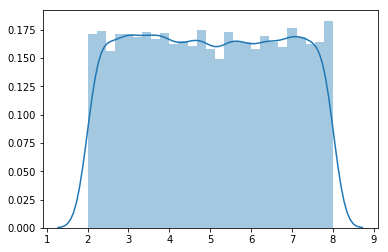

In [0]:
sns.distplot(y)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(400,2048)
        self.fc2 = nn.Linear(2048,2048)
        self.fc3 = nn.Linear(2048,2048)

        self.out = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        x = self.out(x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()

        self.fc1 = nn.Linear(400,1028)
        self.fc2 = nn.Linear(1028,2048)
        self.out = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

In [0]:
def test(net, X_test, y_test):
  with torch.no_grad():
    if not torch.is_tensor(X_test):
      X_test = torch.FloatTensor(X_test).to(device)
    y_pred_test = net(X_test)
    cur_mae = mae(y_pred_test.cpu(), y_test)
  print('test cur_mae', cur_mae)
  return cur_mae

In [0]:
def train(net, train_loader, X_test, y_test, learning_rate=1e-3, num_epochs=200):
    # L1 loss i.e MAE
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.to(device)

    losses = []
    maes = []

    for epoch in range(num_epochs):
        net.train()
        for i_batch, data in enumerate(train_loader, 0):
            X, Y = data
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            out = net(X)

            loss = criterion(out, Y)
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
                cur_mae = test(net, X_test, y_test)
                maes.append(cur_mae)

        losses.append(loss.item())

    return (losses, maes)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

In [0]:
net = SmallNet()

In [0]:
dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

train_loader = DataLoader(dataset, batch_size=200)

In [39]:
%%time
losses, maes = train(net, train_loader, X_test, y_test, \
                     learning_rate=1e-3, num_epochs=200)

test cur_mae 0.39423388937151216
test cur_mae 0.3941031811538913
test cur_mae 0.3939381192032077
test cur_mae 0.39377772191202426
test cur_mae 0.39379294732248565
test cur_mae 0.39374510148203157
test cur_mae 0.39359808314337996
test cur_mae 0.39361231663858676
test cur_mae 0.39349507549440643
test cur_mae 0.39343677619135164
test cur_mae 0.3933440027538516
test cur_mae 0.3932023356262424
test cur_mae 0.3932333813015201
test cur_mae 0.3931236205402591
test cur_mae 0.393059495479224
test cur_mae 0.3930288932625034
test cur_mae 0.39301584342157625
test cur_mae 0.39284730175173066
test cur_mae 0.39275015571748995
test cur_mae 0.3928184411827304
CPU times: user 2min 26s, sys: 8.2 s, total: 2min 34s
Wall time: 2min 35s


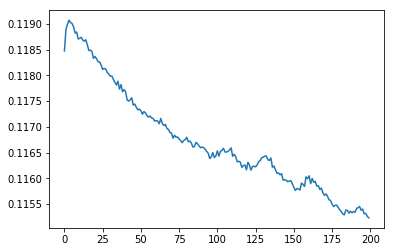

In [43]:
plt.plot(range(len(losses)), losses)

In [44]:
print('best mae:', np.min(maes), 'at', np.argmin(maes)*10)

best mae: 0.39275015571748995 at 180


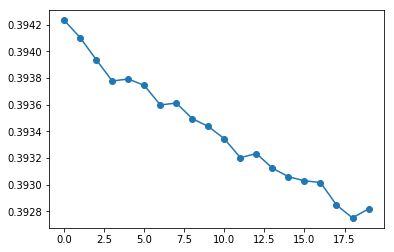

In [45]:
plt.plot(range(len(maes)), maes, marker='o')

In [0]:
with torch.no_grad():
    if not torch.is_tensor(X_test):
      X_test = torch.FloatTensor(X_test).to(device)
      y_pred = net(X_test)
      cur_mae = mae(y_pred.cpu(), y_test)

In [55]:
cur_mae

0.10701028228161942

In [56]:
y_pred

tensor([[3.3493],
        [5.0855],
        [5.7106],
        [7.1647],
        [5.2452],
        [4.3725],
        [2.6250],
        [2.7610],
        [2.9241],
        [2.1730],
        [3.3983],
        [6.7775],
        [6.3653],
        [2.3801],
        [6.1793],
        [3.5205],
        [5.6648],
        [3.9996],
        [3.5641],
        [4.3544],
        [2.3318],
        [7.9210],
        [5.2428],
        [2.7604],
        [6.3507],
        [2.8372],
        [4.3678],
        [5.3440],
        [5.5870],
        [3.1099],
        [2.2238],
        [6.2368],
        [5.4093],
        [4.5988],
        [3.6064],
        [4.4391],
        [5.7797],
        [6.3853],
        [2.8391],
        [4.8243],
        [2.9939],
        [7.4279],
        [5.7825],
        [5.6964],
        [7.5006],
        [5.2084],
        [3.6980],
        [4.2394],
        [4.7948],
        [5.1160],
        [2.2411],
        [3.1293],
        [4.2638],
        [5.6431],
        [4.7199],
        [6

In [57]:
y_test

array([[3.39725841],
       [5.21887982],
       [5.53406494],
       [7.07388675],
       [5.24051336],
       [4.37187138],
       [2.54501495],
       [2.75891751],
       [2.9214481 ],
       [2.50504767],
       [3.48996287],
       [7.0078067 ],
       [6.3682099 ],
       [2.40478841],
       [6.17424967],
       [3.41156041],
       [5.65655651],
       [3.86427133],
       [3.51503733],
       [4.21659822],
       [2.72128096],
       [7.91853412],
       [5.43463493],
       [3.00643377],
       [6.34437254],
       [2.8221084 ],
       [4.36835737],
       [5.26670599],
       [5.68123715],
       [3.41657243],
       [2.10838801],
       [6.22618484],
       [5.30076543],
       [4.68487208],
       [3.61461025],
       [4.43238835],
       [5.89674794],
       [6.39038886],
       [3.19475549],
       [4.87374562],
       [2.96267328],
       [7.42109521],
       [5.79767281],
       [5.68711754],
       [7.05596794],
       [5.20145225],
       [3.70833225],
       [4.244

In [52]:
mae(y, y_pred.cpu())

0.09986465784998219

In [0]:
np.savetxt('y_test.txt', y_test)

In [0]:
np.savetxt('y_pred.txt', y_pred.cpu())

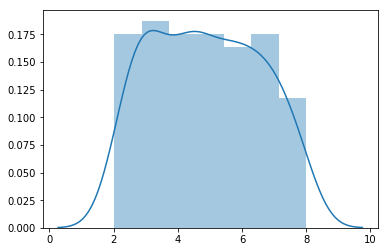

In [62]:
sns.distplot(y_test)

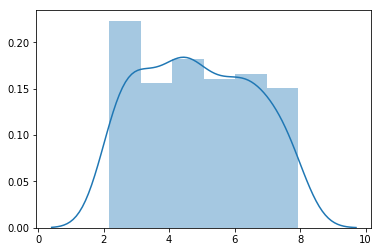

In [65]:
sns.distplot(y_pred.cpu())

In [68]:
mae(y_pred.cpu(), y_test)

0.10701028228161942